# Create Dataset and Dataloader

In [1]:
# CHECK CUDA
import torch

if not torch.cuda.is_available():
  raise Exception("GPU not availalbe. CPU training will be too slow.")

print("device name", torch.cuda.get_device_name(0))

device name GeForce GTX 1060 6GB


In [2]:
#モジュールのimport
from torch.utils import data
from PIL import Image
import os
import sys
import numpy as np
from natsort import natsorted
import shutil
import glob
import albumentations as albu

import cv2
import matplotlib.pyplot as plt

In [3]:
import sys
sys.path.append('../')

In [4]:
da = __import__("pytorch_advanced.3_semantic_segmentation.utils.data_augumentation", fromlist=['object'])

In [5]:
#da = __import__("utils.data_augumentation", fromlist=['object'])

In [6]:
DATA_DIR = "../data"

## dataの読み込み

In [7]:
train_img_list = natsorted(glob.glob(DATA_DIR+"/train/img/*"))
train_anno_list = natsorted(glob.glob(DATA_DIR+"/train/anno/*"))

test_img_list = natsorted(glob.glob(DATA_DIR+"/test/img/*"))
test_anno_list = natsorted(glob.glob(DATA_DIR+"/test/anno/*"))

val_img_list = natsorted(glob.glob(DATA_DIR+"/valid/img/*"))
val_anno_list = natsorted(glob.glob(DATA_DIR+"/valid/anno/*"))

In [8]:
#学習用アノテーション画像の二値化処理
for i in range(len(train_anno_list)):
    im = Image.open(train_anno_list[i])
    im_list = np.asarray(im)
    X = im_list
    Y = np.where(X>1,1,X)
    pil_img = Image.fromarray(Y)
    pil_img.save(train_anno_list[i])

#検証用アノテーション画像の二値化処理
for i in range(len(val_anno_list)):
    im = Image.open(val_anno_list[i])
    im_list = np.asarray(im)
    X = im_list
    Y = np.where(X>1,1,X)
    pil_img = Image.fromarray(Y)
    pil_img.save(val_anno_list[i])
    
#検証用アノテーション画像の二値化処理
for i in range(len(test_anno_list)):
    im = Image.open(test_anno_list[i])
    im_list = np.asarray(im)
    X = im_list
    Y = np.where(X>1,1,X)
    pil_img = Image.fromarray(Y)
    pil_img.save(test_anno_list[i])

In [36]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

class Dataset(BaseDataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.

    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)

    """

    CLASSES = ['unlabelled', 'billboard'] #変更

    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.images_fps = images_dir
        self.masks_fps = masks_dir

        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]

        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __getitem__(self, i):

        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)

        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image, mask

    def __len__(self):
        return len(self.images_fps)

In [37]:
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

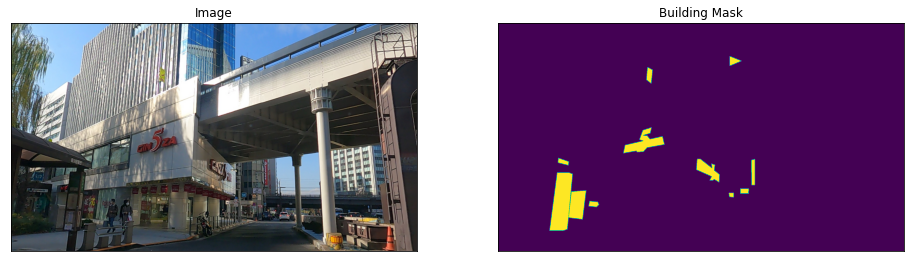

In [38]:
dataset = Dataset(train_img_list, train_anno_list, classes=['billboard'])

image, mask = dataset[6] # get some sample
visualize(
    image=image, 
    building_mask=mask.squeeze(),
)

In [39]:
import albumentations as albu

def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),

        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        albu.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        #albu.RandomCrop(height=320, width=320, always_apply=True),

        albu.IAAAdditiveGaussianNoise(p=0.2),
        albu.IAAPerspective(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.IAASharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(384, 480)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform

    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose

    """

    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

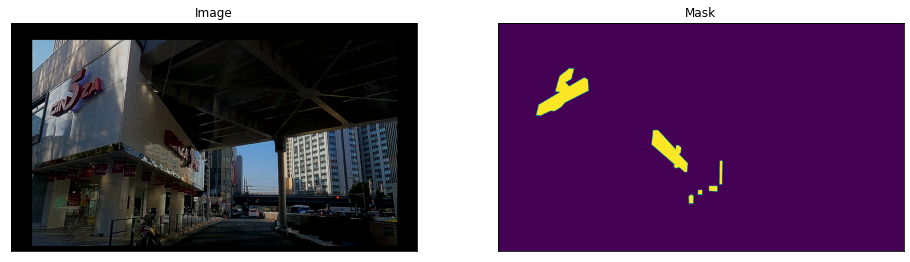

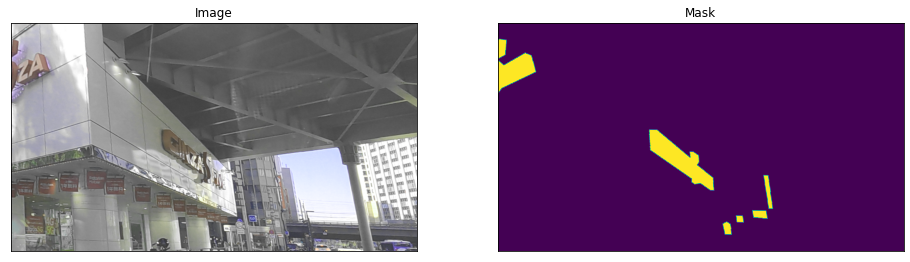

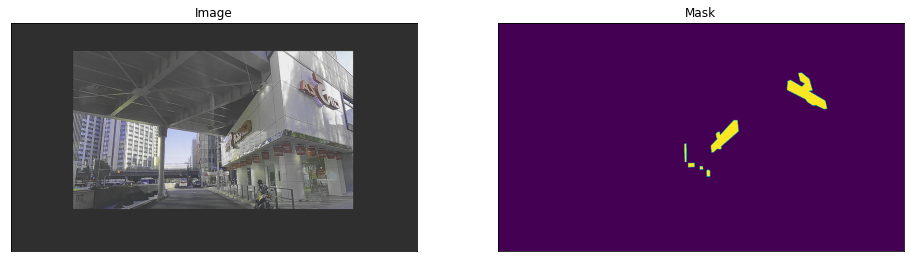

In [40]:
augmented_dataset = Dataset(
    train_img_list, 
    train_anno_list, 
    augmentation=get_training_augmentation(), 
    classes=['billboard'],
)

# same image with different random transforms
for i in range(3):
    image, mask = augmented_dataset[8]
    visualize(image=image, mask=mask.squeeze(-1))

In [41]:
import torch
import numpy as np
import segmentation_models_pytorch as smp

ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['billboard']
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multicalss segmentation
DEVICE = 'cuda'

# create segmentation model with pretrained encoder
model = smp.DeepLabV3(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [42]:
train_dataset = Dataset(
    train_img_list, 
    train_anno_list, 
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

valid_dataset = Dataset(
    val_img_list, 
    val_anno_list, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=12)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=4)

In [43]:
loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

In [44]:
optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

In [45]:
loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

In [46]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [ ]:
max_score = 0


#train accurascy, train loss, val_accuracy, val_loss をグラフ化できるように設定．
x_epoch_data = []
train_dice_loss = []
train_iou_score = []
valid_dice_loss = []
valid_iou_score = []


for i in range(0, 40):

    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)

    x_epoch_data.append(i)
    train_dice_loss.append(train_logs['dice_loss'])
    train_iou_score.append(train_logs['iou_score'])
    valid_dice_loss.append(valid_logs['dice_loss'])
    valid_iou_score.append(valid_logs['iou_score'])

    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model_Unet_resnet50.pth')
        print('Model saved!')

    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
train:   0%|          | 0/55 [00:00<?, ?it/s]